In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from scipy import signal
from scipy import fftpack

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie
from allensdk.brain_observatory.sync_dataset import Dataset

In [4]:
%matplotlib notebook

### Load EEG

In [5]:
data_folder = r"C:\Users\lesliec\data\eeg_pilot\mouse507190\pilot1_2020-02-28_10-33-11\recording1"
exp = EEGexp(data_folder)

In [6]:
eegdata = np.load(os.path.join(os.path.dirname(exp.eegdata_file), 'data_2500Hz.npy')) * exp.bits_to_uvolts / 1000.
masterts = np.load(os.path.join(os.path.dirname(exp.eegtimestamps_file), 'timestamps_master_2500Hz.npy'))
sample_rate = 2500.

In [7]:
pl_cha = 5
cha = eegdata[:, pl_cha]

### Load iso and running

In [8]:
sync_data = exp.load_sync_dataset()
iso_level, isotime = exp.load_analog_iso(sync_data) # still need to pass it the Dataset instance

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\allensdk\brain_observatory\sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


In [9]:
iso5inds = np.where(iso_level > 4.90)[0]
iso5_times = isotime[np.array([iso5inds[0], iso5inds[-1]])]
print(iso5_times)

iso2inds = np.where((iso_level > 1.80) & (iso_level < 2.2))[0]
iso2inds = iso2inds[iso2inds > iso5inds[-1]] # removes iso2 level during initial increase to iso5
iso2_times = isotime[np.array([iso2inds[0], iso2inds[-1]])]
print(iso2_times)

[ 645.712 1189.232]
[1194.048 1867.552]


In [10]:
linear_velocity, runtime = exp.load_running(sync_data)

In [11]:
# simple mean smoothing filter
smooth_velocity = np.zeros_like(linear_velocity)

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k, len(linear_velocity)-k-1):
    # each point is the average of k surrounding points
    smooth_velocity[i] = np.mean(linear_velocity[i-k:i+k])

### Plot running and EEG

In [12]:
# can session be chunked into 10 min epochs?
bubs = np.arange(0, np.shape(eegdata)[0], 10*60*sample_rate, dtype='int')
print(bubs)

[      0 1500000 3000000 4500000 6000000 7500000 9000000]


<IPython.core.display.Javascript object>


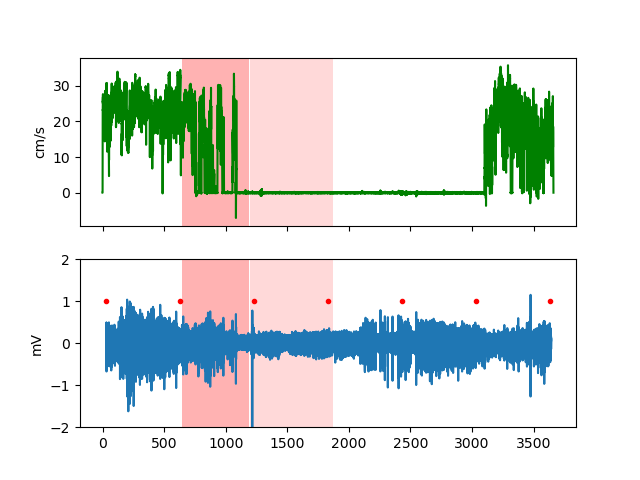

In [13]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(runtime, smooth_velocity, 'g')
axs[0].set_ylabel('cm/s')
axs[0].axvspan(iso5_times[0], iso5_times[1], facecolor='r', alpha=0.3)
axs[0].axvspan(iso2_times[0], iso2_times[1], facecolor='r', alpha=0.15)

axs[1].plot(masterts, cha)
axs[1].set_ylim((-2, 2))
axs[1].set_ylabel('mV')
axs[1].axvspan(iso5_times[0], iso5_times[1], facecolor='r', alpha=0.3)
axs[1].axvspan(iso2_times[0], iso2_times[1], facecolor='r', alpha=0.15)

axs[1].plot(masterts[bubs], np.ones(len(bubs)), '.r')

### Calculate power in theta band for each electrode

##### Map of electrodes

In [15]:
# coordinates relative to bregma
# ML: neg= mouse left, pos= mouse right

EEG_ML = np.array([-4.05, -2.24, -1.0, -4.13, -2.88, -1.13, -4.05, -2.88, -1.12, -3.5,
                   -2.12, -1.93, -0.5, -1.5, -0.5, 0.5, 1.5, 0.5, 1.93, 2.12,
                   3.5, 1.12, 2.88, 4.05, 1.13, 2.88, 4.13, 1.0, 2.24, 4.05
                  ])

EEG_AP = np.array([-4.14, -4.14, -4.14, -3.04, -3.04, -3.04, -1.96, -1.96, -1.96, -0.48,
                   -0.48, 1.04, 1.04, 2.3, 2.3, 2.3, 2.3, 1.04, 1.04, -0.48,
                   -0.48, -1.96, -1.96, -1.96, -3.04, -3.04, -3.04, -4.14, -4.14, -4.14
                  ])

<IPython.core.display.Javascript object>


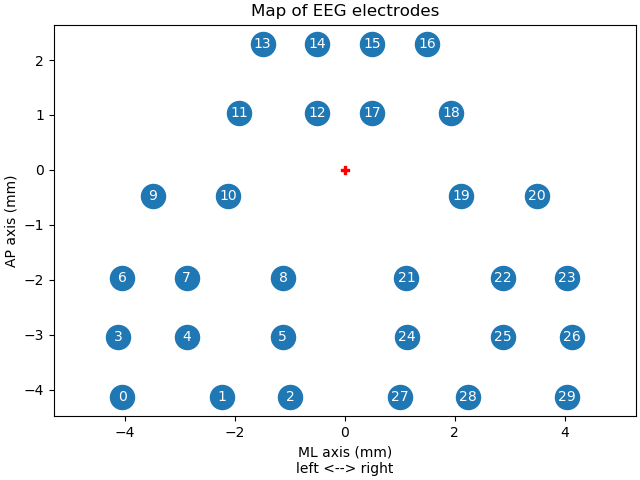

Text(0.5, 1.0, 'Map of EEG electrodes')

In [16]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(EEG_ML, EEG_AP, s=300)
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEG_ML)):
    ax.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="w")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Map of EEG electrodes')

In [18]:
timewindow = 10. * 60. # seconds
choose_inds = np.arange(0, int(timewindow*sample_rate))

welchwinlen = 1 * sample_rate
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [28]:
anoffset = int((iso2_times[0]-masterts[0])*sample_rate)
print(anoffset)

2910535


In [29]:
frex, Pxx_den = signal.welch(eegdata[choose_inds, :], sample_rate, nperseg=welchwinlen, axis=0)
# frex, Pxx_den = signal.welch(eegdata[choose_inds+anoffset, :], sample_rate, nperseg=welchwinlen, axis=0)

In [30]:
print(np.shape(Pxx_den))

(1251, 30)


In [31]:
# choose theta band
freq_band = [6, 10]
frexinds = (frex > freq_band[0]) & (frex < freq_band[1])

In [32]:
print(frex[frexinds])

[7. 8. 9.]


In [33]:
theta_power = np.mean(Pxx_den[frexinds, :], axis=0)
print(np.shape(theta_power))

(30,)


<IPython.core.display.Javascript object>


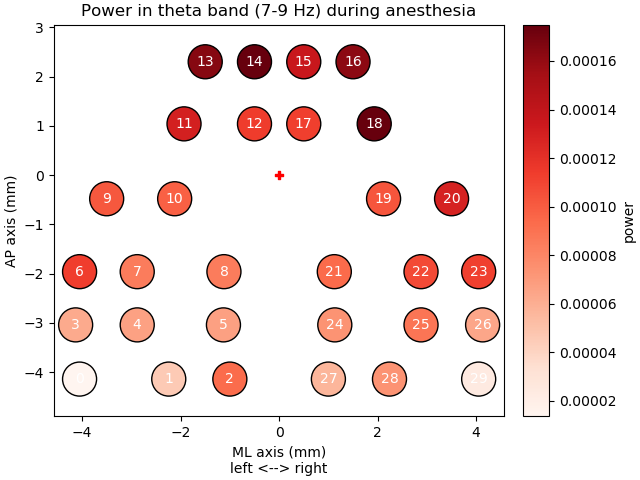

In [35]:
fig, ax = plt.subplots(constrained_layout=True)

bug = ax.scatter(EEG_ML, EEG_AP, c=theta_power, s=600, cmap='Reds', vmin=0, vmax=0.0005, edgecolors='k') #, vmin=0, vmax=0.0005
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEG_ML)):
    ax.annotate(str(ind),  xy=(EEG_ML[ind], EEG_AP[ind]), ha='center', va='center', color="w")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Power in theta band (7-9 Hz) during wake')
cb = fig.colorbar(bug, ax=ax)
cb.set_label('power')

### Let's try looking at PSD of different window lengths.

In [12]:
timechunk = 10. * 60. # seconds
baseinds = np.arange(0, int(timechunk*sample_rate))
print(len(baseinds))

1500000


In [13]:
wake10 = eegdata[baseinds, :]

##### Need to specify Welch's window length

In [14]:
welchwinlen = 1 * sample_rate
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [15]:
f10, Pxx_den10 = signal.welch(wake10, sample_rate, nperseg=welchwinlen, axis=0)

In [16]:
frinds = f10 < 200

<IPython.core.display.Javascript object>


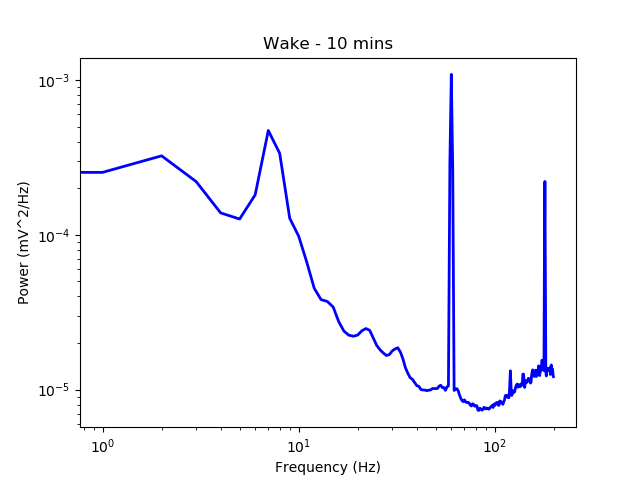

Text(0.5, 1.0, 'Wake - 10 mins')

In [17]:
fig, ax = plt.subplots()
    
ax.loglog(f10[frinds], np.mean(Pxx_den10, axis=1)[frinds], color='b', linewidth=2, label=('Wake'))
# ax.loglog(fa[frinds], np.mean(Pxx_dena, axis=1)[frinds], color=ancolor, linewidth=2, label=('Anesthetized'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Wake - 10 mins')
# ax.legend()

##### Try small window

In [18]:
timechunk = 1. * 60. # seconds
baseinds = np.arange(0, int(timechunk*sample_rate))
print(len(baseinds))

150000


In [19]:
wake1 = eegdata[baseinds, :]

In [20]:
f1, Pxx_den1 = signal.welch(wake1, sample_rate, nperseg=welchwinlen, axis=0)

In [21]:
frinds = f1 < 200

<IPython.core.display.Javascript object>


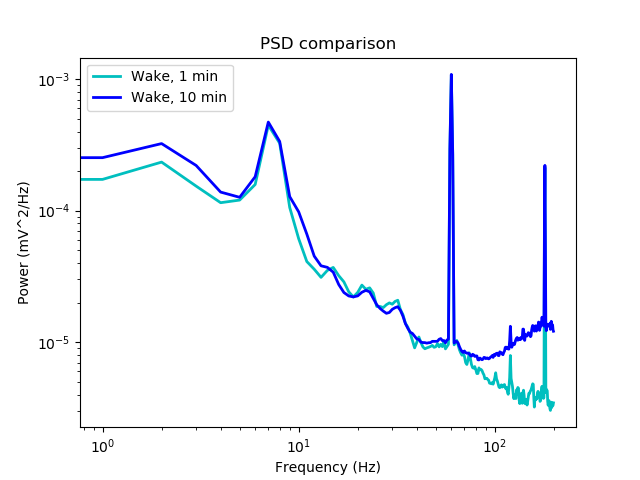

In [22]:
fig, ax = plt.subplots()
    
ax.loglog(f1[frinds], np.mean(Pxx_den1, axis=1)[frinds], color='c', linewidth=2, label=('Wake, 1 min'))
ax.loglog(f10[frinds], np.mean(Pxx_den10, axis=1)[frinds], color='b', linewidth=2, label=('Wake, 10 min'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('PSD comparison')
ax.legend()

In [29]:
print(len(Pxx_den1))
print(len(Pxx_den10))
print(len(f10))

1251
1251
1251


### Loop through 10 min epochs and calculate PSD

In [30]:
timechunk = 10. * 60. # seconds

In [31]:
power_spectra = np.zeros((len(bubs)-1, len(Pxx_den1)))
for k, begind in enumerate(bubs[:-1]):
    baseinds = np.arange(0, int(timechunk*sample_rate)) + begind
    
    f, Pxx_temp = signal.welch(eegdata[baseinds, :], sample_rate, nperseg=welchwinlen, axis=0)
    power_spectra[k,:] = np.mean(Pxx_temp, axis=1)

In [32]:
print(np.shape(power_spectra))

(6, 1251)


<IPython.core.display.Javascript object>


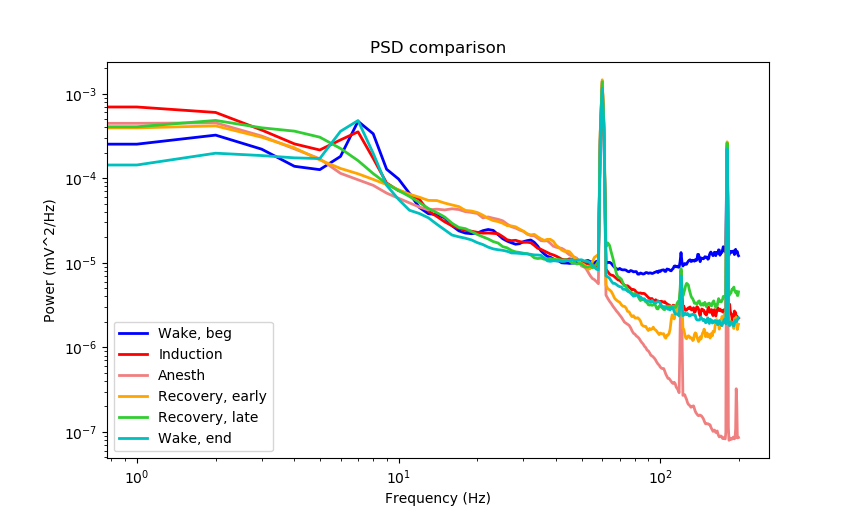

In [34]:
fig, ax = plt.subplots()
    
ax.loglog(f[frinds], power_spectra[0, frinds], color='b', linewidth=2, label=('Wake, beg'))
ax.loglog(f[frinds], power_spectra[1, frinds], color='r', linewidth=2, label=('Induction'))
ax.loglog(f[frinds], power_spectra[2, frinds], color='lightcoral', linewidth=2, label=('Anesth'))
ax.loglog(f[frinds], power_spectra[3, frinds], color='orange', linewidth=2, label=('Recovery, early'))
ax.loglog(f[frinds], power_spectra[4, frinds], color='limegreen', linewidth=2, label=('Recovery, late'))
ax.loglog(f[frinds], power_spectra[5, frinds], color='c', linewidth=2, label=('Wake, end'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('PSD comparison')
ax.legend()